In [330]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from scipy.stats import pearsonr
from sklearn.metrics import r2_score


# LN model V1
## 10/30/24
- Working with 4 types of nonlinearities. 
- Uses the same bin size for spike train and stimulus. 

In [331]:
sta = np.load('sta_train_data.npy')

In [498]:
train_stim= np.load('train_stim_clipped.npy')
train_spikes = np.load('train_spikes.npy',allow_pickle=True)
test_stim = np.load('test_stim_clipped.npy')
test_spikes = np.load('test_spikes.npy',allow_pickle=True)
time_points = np.arange(0, 31, 1/60)
# plt.plot(test_stim[5])


In [500]:
midpoint = len(test_spikes) // 2

# Split into train and test sets
train_set = test_spikes[:midpoint]
test_set = test_spikes[midpoint:]


In [ ]:
frame_rate = 60  # Hz
frame_duration = 1 / frame_rate  # seconds per frame
total_duration = 31  # Total duration in seconds

def binarize_spike_trains(spikes_array, total_duration):
    """
    Binarize spike trains based on frame duration, allowing multiple spikes per frame.
    
    Args:
        spikes_array: Object array where each element is an array of spike times for a trial.
        total_duration: Total duration of each trial in seconds.
    
    Returns:
        A spike count array with shape (num_trials, num_frames).
    """
    # Calculate the number of frames based on the total duration and frame duration
    num_frames = int(np.ceil(total_duration / frame_duration))
    
    # Initialize the spike count array
    spike_count_trains = np.zeros((len(spikes_array), num_frames), dtype=int)
    
    for i, spike_times in enumerate(spikes_array):
        # Convert spike times to corresponding frame indices
        frame_indices = (spike_times / frame_duration).astype(int)
        frame_indices = frame_indices[frame_indices < num_frames]  # Ensure indices are within bounds
        
        # Count spikes per frame by incrementing for each spike occurrence
        for frame_idx in frame_indices:
            spike_count_trains[i, frame_idx] += 1  # Increment count instead of setting to 1
    
    return spike_count_trains


train_binarized_spikes = binarize_spike_trains(train_spikes, total_duration)
test_binarized_spikes = binarize_spike_trains(test_spikes, total_duration)
tesxt_binarized_spikes = binarize_spike_trains(test_set, total_duration)
print("Binarized train spikes shape:", train_binarized_spikes.shape)
print("Binarized test spikes shape:", test_binarized_spikes.shape)
print(f"Sanity check, Stimulus shape 2nd dim: {train_stim.shape[1]}, spikes {test_binarized_spikes.shape[1]}")


Binarized train spikes shape: (15, 1860)
Binarized test spikes shape: (15, 1860)
Sanity check, Stimulus shape 2nd dim: 1860, spikes 1860


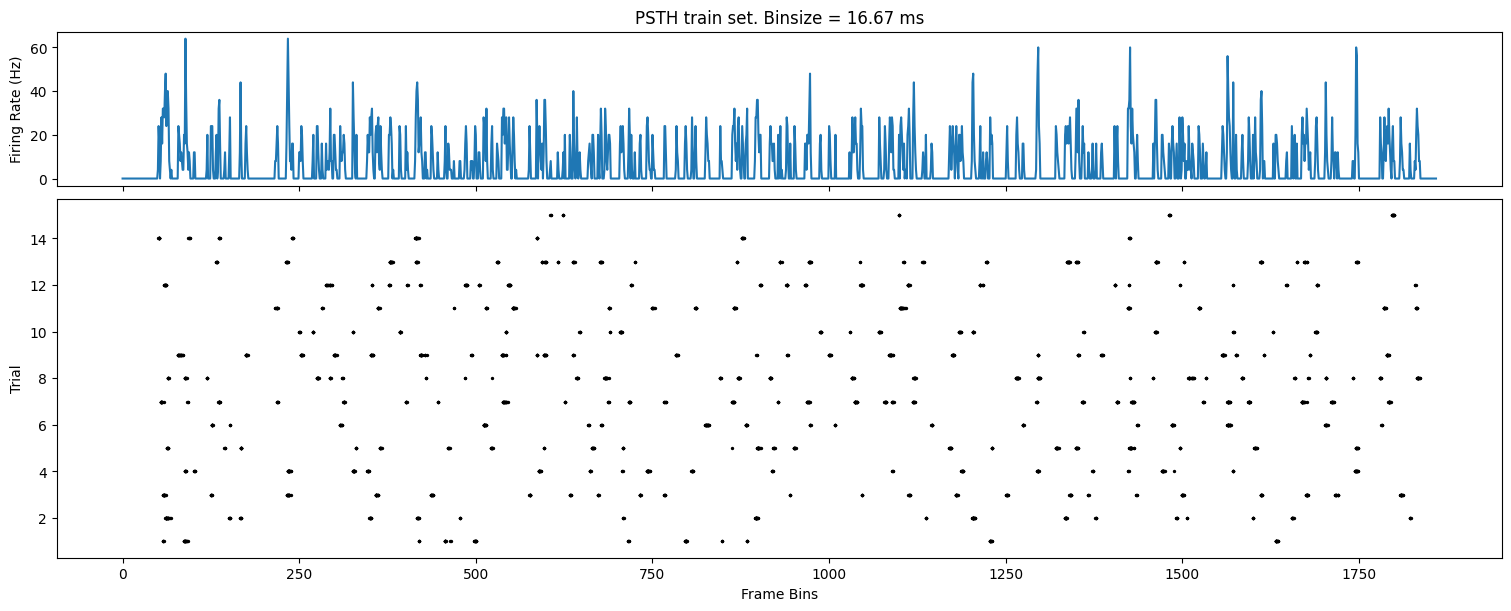

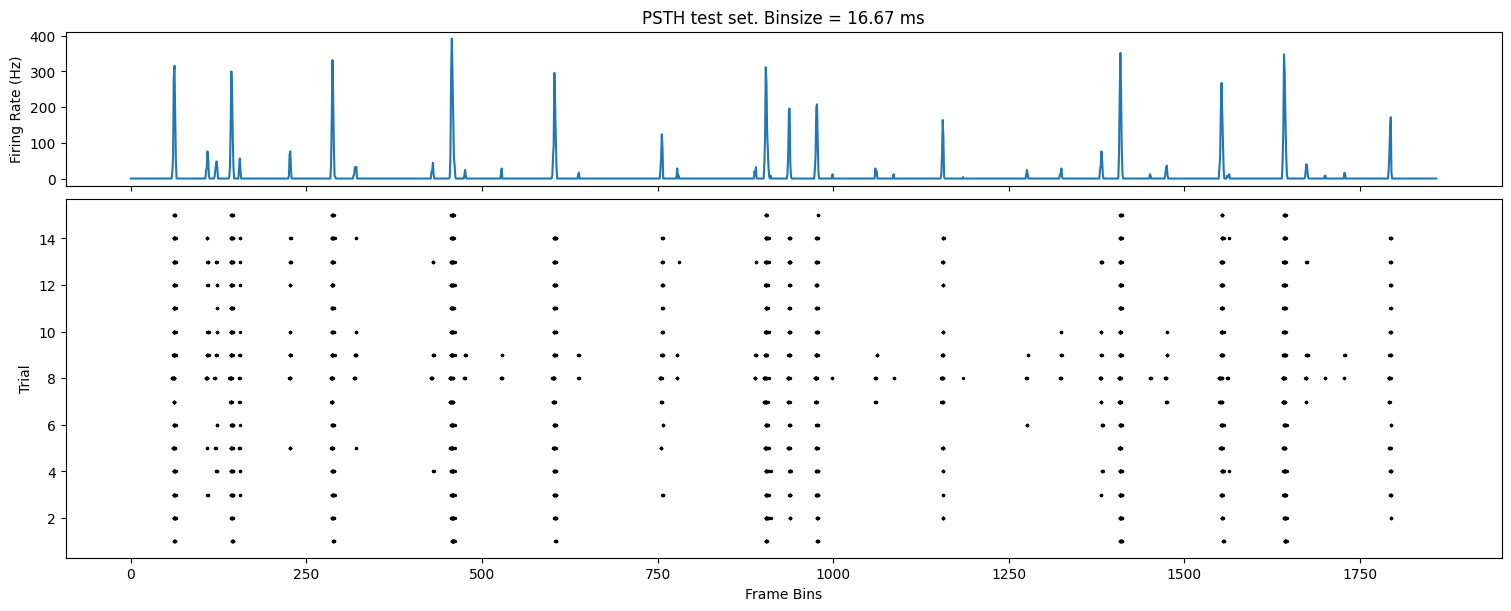

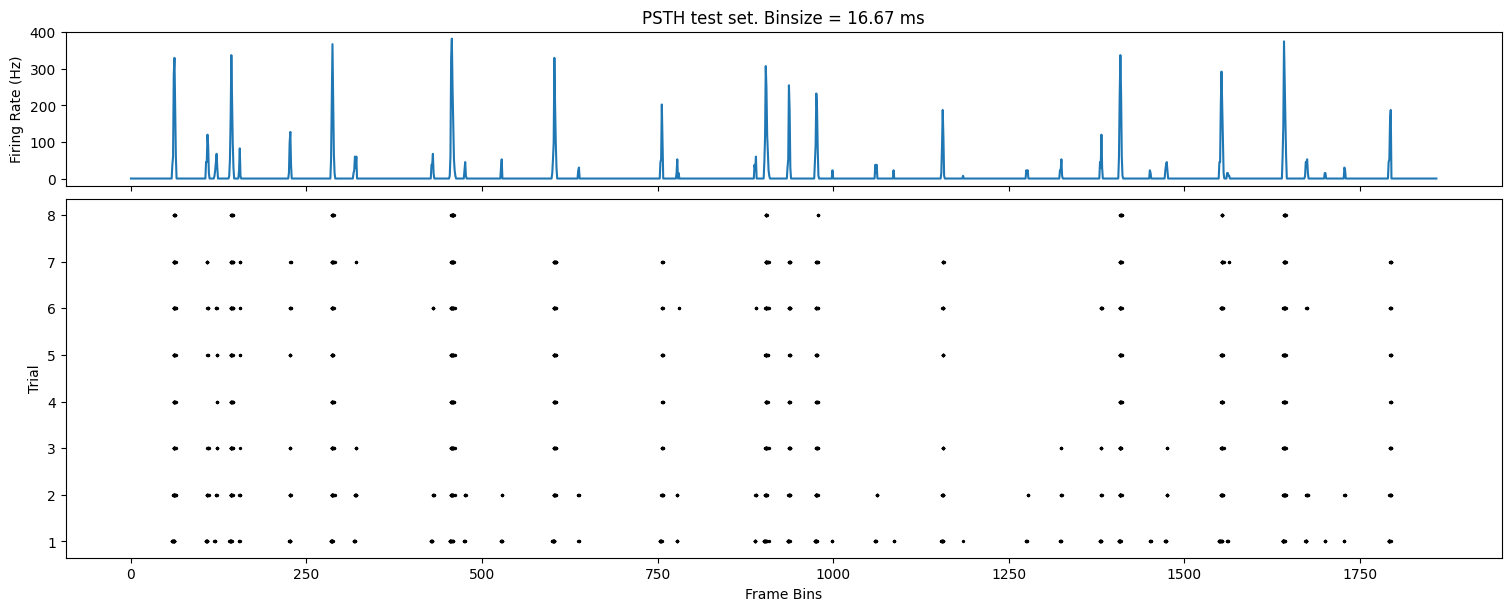

array([0., 0., 0., ..., 0., 0., 0.])

In [502]:
def plot_psth(binarized_spikes, title, frame_rate=60, plotFlag=True):
    # Convert bin duration to seconds for firing rate calculation
    bin_duration = 1 / frame_rate  # Duration of each bin in seconds
    bin_size_ms = bin_duration * 1000  # Convert bin size to milliseconds for display
    # Calculate the PSTH as the mean firing rate per bin (Hz)
    psth = np.mean(binarized_spikes, axis=0) / bin_duration 
    if plotFlag:
        fig, axs = plt.subplots(nrows=2, figsize=(15, 6), layout="constrained", sharex=True, height_ratios=[3, 7])

        axs[0].plot(range(len(psth)), psth)
        axs[0].set_ylabel("Firing Rate (Hz)")
        axs[0].set_title(f"PSTH {title} set. Binsize = {bin_size_ms:2.2f} ms")

         # Raster plot (show multiple spikes per bin by repeating the frame index)
        for i in range(binarized_spikes.shape[0]):
            spike_counts = binarized_spikes[i]  # Spike counts for each bin in this trial
            for bin_idx, count in enumerate(spike_counts):
                if count > 0:
                    axs[1].scatter(
                        np.repeat(bin_idx, count),  # Repeat the bin index for each spike
                        np.full(count, i + 1),      # Trial number repeated for each spike
                        color="black", s=2          # Smaller dots for clarity
                    )

        axs[1].set_xlabel("Frame Bins")
        axs[1].set_ylabel("Trial")
        # plt.xlim([25,50])
        plt.show()
    return psth

train_psth = plot_psth(train_binarized_spikes, 'train')
test_psth = plot_psth(test_binarized_spikes, 'test')
plot_psth(tesxt_binarized_spikes, 'test')

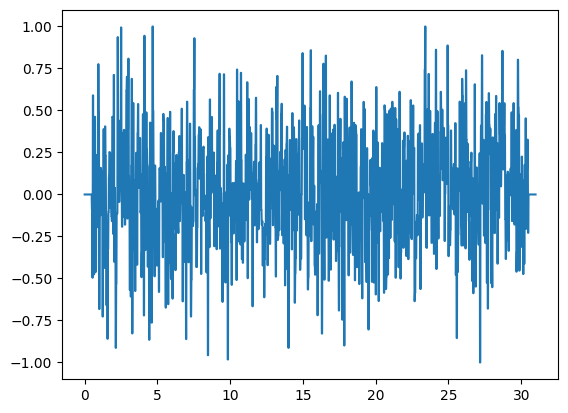

In [335]:
# test_stim = np.clip(test_stim, -1, 1)
plt.plot(time_points, test_stim[0])

## Now we are ready for the LN model

The STA is the L part. We need to normalize so that the std of the convolution has values in the same range independent of the cell?

In [336]:
sta /= sta.std() #Normalizing the sta

1.0


Text(0.5, 1.0, 'Normalized STA. Std = 1 ')

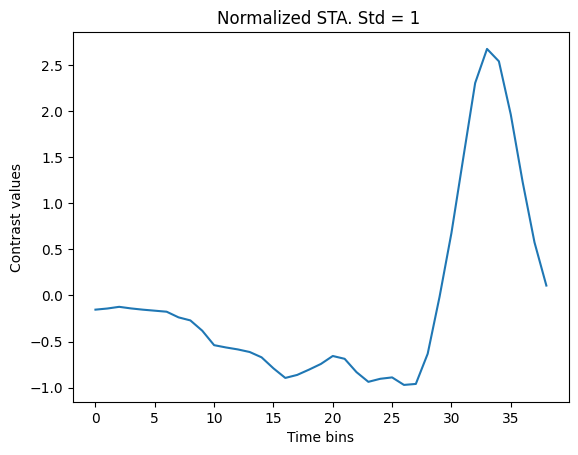

In [337]:
print(sta.std())
plt.plot(sta)
plt.xlabel('Time bins')
plt.ylabel('Contrast values')
plt.title(f'Normalized STA. Std = {round(sta.std())} ')

In [338]:
## Training data just to check it works
# stim_x = np.load('training_stimulus_TG.npy')
# spikes_x = np.load('training_spikes_TG.npy')
# sta_x = np.load('training_sta_TG.npy')
# print("stim shape",stim_x.shape)
# print("spikes shape",spikes_x.shape)
# print("sta shape",sta_x.shape)


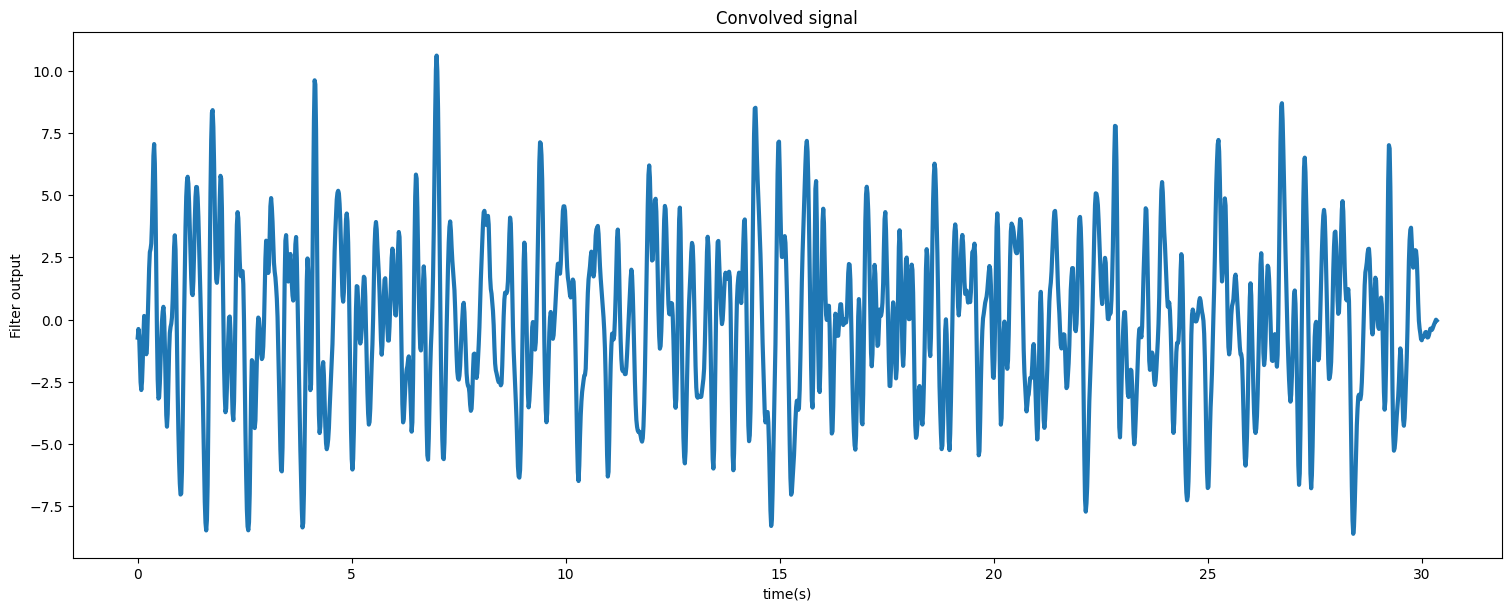

In [480]:
def convolve_stimulus_with_sta(stimulus_array, cell_sta, plotFlag=True):
    """
    Use np.convolve to compute the trial-by-trial convolution
    of the visual stimulus with a cell's spike-triggered avg.
    """
    conv_list = []
    
    for trial in stimulus_array:
        conv = np.convolve(trial, cell_sta[::-1], mode="valid")  #Flipped STA
        conv_list.append(conv)
    
    if plotFlag:
        fig, ax = plt.subplots(figsize=(15, 6), layout="constrained")
        time_points = np.arange(0, 31, 1/60)
        time_points = time_points[0:len(np.array(conv_list)[0])]
        ax.plot(time_points,np.array(conv_list)[0], lw=3) #train stim
        ax.set_xlabel("time(s)")
        ax.set_ylabel("Filter output")
        ax.set_title("Convolved signal")
        plt.show()
        
    return np.array(conv_list)

convolved_signal = convolve_stimulus_with_sta(test_stim, sta, plotFlag=True)
# convolved_signal = convolved_signal[0] #For the test stimulus. 



In [481]:
num_past_pulses = train_binarized_spikes.shape[1] - convolved_signal.shape[1] #np.convolve only takes the valid part of the convolution (signal and filter lengths must be same). 
num_past_pulses #                                                             #This creates a difference in the shape of the convolved signal we need to correct for


38

C:\Users\SchwartzLab\AppData\Local\Temp\ipykernel_39344\3532543139.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


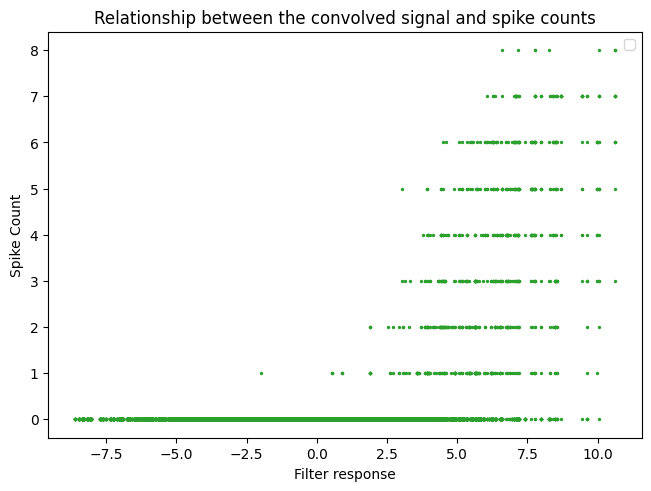

In [482]:
#Let's fit the non linearity
fig, ax = plt.subplots(layout="constrained")
ax.scatter(convolved_signal.ravel(), test_binarized_spikes[:, num_past_pulses:].ravel(), c="tab:green", s=2)
ax.set_xlabel("Filter response")
ax.set_ylabel("Spike Count")
ax.set_title("Relationship between the convolved signal and spike counts")
plt.legend()
plt.show()

empirical NL w/o NANs (19,)
resampled p (20,)


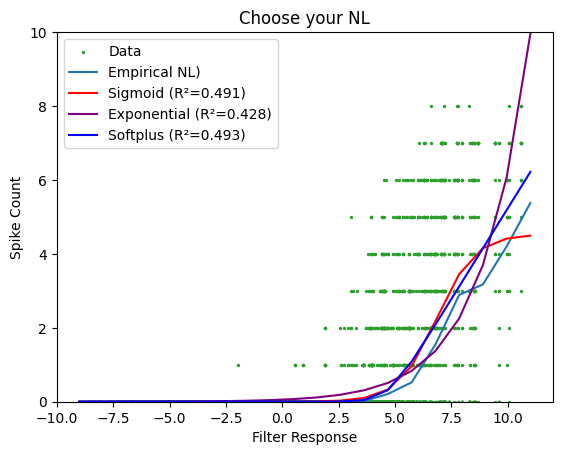

In [497]:
def NL(spike_train, convolved_signal, nbins, plotFlag=True):
    x_values = np.linspace(
        start=np.floor(convolved_signal.min()),
        stop=np.ceil(convolved_signal.max()),
        num=nbins
        )
    # x_values = np.linspace(
    #     start=convolved_signal.min() - 0.1 * abs(convolved_signal.min()),  # add padding to avoid edge effects
    #     stop=convolved_signal.max() + 0.1 * abs(convolved_signal.max()),
    #     num=nbins 
    # )
    #Empirical NL
    vectorized_spike_train= spike_train[:, num_past_pulses:].ravel()
    # vectorized_spike_train= spike_train[:, num_past_pulses//2:-num_past_pulses//2].ravel()
    digitized_filter_output = np.digitize(convolved_signal.ravel(),x_values)
    eNL = [np.nanmean(vectorized_spike_train[digitized_filter_output == j]) for j in range(nbins)]
    eNL = np.array(eNL)
    
    valid_indices = ~np.isnan(eNL)
    filtered_response = x_values[valid_indices]
    print("empirical NL w/o NANs",filtered_response.shape)
    filtered_p = eNL[valid_indices]
    interpolate = interp1d(filtered_response, filtered_p, kind='linear', fill_value="extrapolate")
    resampled_filtered_p = interpolate(x_values)
    print("resampled p",resampled_filtered_p.shape)

    def sigmoid(x, L, k, x0):
        return L / (1 + np.exp(-k * (x - x0)))
    initial_guess_sigm = [np.max(filtered_p), 0.05, np.mean(filtered_response)]

    def exponential(x, a, b,c,d):
        return a * np.exp(b * x + c) +d
    
    def softplus(x, a, b,c,d):
        return a * np.log(1 + np.exp(b * x + c)) + d
    initial_guess_soft = [1.0,1.0,1.0,1.0]

    # initial_guess_exp = [np.max(filtered_p), 0.1, np.mean(filtered_p)]
    initial_guess_exp = [2.0, 0.5, -3.0,0.0]
    try:
        optimal_parameters_sigm,_ =  curve_fit(
           f=sigmoid,  # the function we'd like to fit
           xdata=convolved_signal.ravel(),  # x axis values
           ydata=vectorized_spike_train,  # y axis values
           p0=initial_guess_sigm,  # initial parameters
           bounds=([0, -np.inf, -np.inf], np.inf),  # bounds
           maxfev=4000,  # just making sure the algorithm converges
        )
        optimal_parameters_exp, _ = curve_fit(
           f=exponential,  
           xdata=convolved_signal.ravel(), 
           ydata=vectorized_spike_train,  
           p0=initial_guess_exp, 
           bounds=([0, -np.inf, -np.inf, 0.0], np.inf), 
           maxfev=4000, 
        )
        optimal_parameters_softplus, _ = curve_fit(
            softplus, convolved_signal.ravel(), vectorized_spike_train,
            p0=initial_guess_soft, maxfev=4000
        )

        y_fit_sigm = sigmoid(x_values, *optimal_parameters_sigm)
        y_fit_exp = exponential(x_values, *optimal_parameters_exp)
        y_fit_softplus = softplus(x_values, *optimal_parameters_softplus)
        def calculate_r_squared(y_true, y_pred):
            residual_sum_of_squares = np.sum((y_true - y_pred) ** 2)
            total_sum_of_squares = np.sum((y_true - np.mean(y_true)) ** 2)
            return 1 - (residual_sum_of_squares / total_sum_of_squares)
        r_squared_sigm = calculate_r_squared(vectorized_spike_train, sigmoid(convolved_signal.ravel(), *optimal_parameters_sigm))
        r_squared_exp = calculate_r_squared(vectorized_spike_train, exponential(convolved_signal.ravel(), *optimal_parameters_exp))
        r_squared_softplus = calculate_r_squared(vectorized_spike_train, softplus(convolved_signal.ravel(), *optimal_parameters_softplus))
        


        if plotFlag:
            plt.scatter(convolved_signal.ravel(), vectorized_spike_train, c="tab:green", s=2, label="Data")
            plt.plot(x_values, resampled_filtered_p, label=f'Empirical NL)')
            plt.plot(x_values, y_fit_sigm, label=f'Sigmoid (R²={r_squared_sigm:.3f})', color='red')
            plt.plot(x_values, y_fit_exp, label=f'Exponential (R²={r_squared_exp:.3f})', color='purple')
            plt.plot(x_values, y_fit_softplus, label=f'Softplus (R²={r_squared_softplus:.3f})', color='blue')
            plt.xlabel('Filter Response')
            plt.ylabel('Spike Count')
            plt.legend()
            plt.title("Choose your NL")
            plt.ylim([0, np.max(spike_train[:, num_past_pulses:].ravel()) + 2])
            plt.show()
        
    except RuntimeError as e:
        print("Fitting error:", e)

    return resampled_filtered_p, y_fit_sigm, y_fit_exp, y_fit_softplus,optimal_parameters_sigm, optimal_parameters_exp, optimal_parameters_softplus

eNL, y_fit_sigm, y_fit_exp, y_fit_softplus,optimal_parameters_sigm, optimal_parameters_exp, optimal_parameters_softplus = NL(test_binarized_spikes, convolved_signal, 20)   

C:\Users\SchwartzLab\AppData\Local\Temp\ipykernel_39344\3418681896.py:10: RuntimeWarning: invalid value encountered in log
  return a * np.log(b * x + c) + d


ValueError: Residuals are not finite in the initial point.

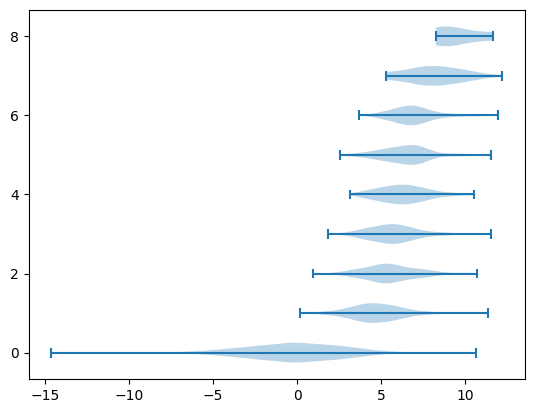

In [403]:
# plt.scatter(convolved_signal.ravel(), vectorized_spike_train, c="tab:green", s=2, label="Data")
plt.violinplot([convolved_signal.ravel()[vectorized_spike_train == i] for i in range(9)], range(9), vert=False)


def exponential(x, a, b, c, d):
    return a * np.exp(b * x + c) + d
initial_guess_exp = [2.0, 0.05, -3.0, 0.01]

def logarithmic(x, a, b, c, d):
    return a * np.log(b * x + c) + d
initial_guess_log = [2.0, 0.05, -3.0, 0.01]


optimal_parameters_log, _ = curve_fit(
    f=logarithmic,  
    xdata=vectorized_spike_train + 1, 
    ydata= convolved_signal.ravel(), 
    p0=initial_guess_log, 
    bounds=([0.5, -np.inf, -np.inf, -np.inf], np.inf), 
    maxfev=4000, 
)

optimal_parameters_exp, _ = curve_fit(
    f=exponential,  
    xdata=convolved_signal.ravel(), 
    ydata=vectorized_spike_train,  
    p0=initial_guess_exp, 
    bounds=([0, -np.inf, -np.inf, -np.inf], np.inf), 
    maxfev=4000, 
)

x_values = np.linspace(
    convolved_signal.ravel().min(),
    convolved_signal.ravel().max(),
    100
)

y_values = np.linspace(
    vectorized_spike_train.min(),
    vectorized_spike_train.max(),
    100 
)

from sklearn.metrics import r2_score
y_fit = exponential(convolved_signal.ravel(), *optimal_parameters_exp)
print(r2_score(vectorized_spike_train, y_fit))
y_fit_exp = exponential(x_values, *optimal_parameters_exp)

plt.plot(x_values, y_fit_exp, label='Fitted Exponential', color='green')


x_fit = logarithmic(vectorized_spike_train + 1, *optimal_parameters_exp)
print(r2_score(convolved_signal.ravel(), x_fit - 1))
x_fit_exp = exponential(y_values, *optimal_parameters_exp)

plt.plot(x_fit - 1, y_values, label='Fitted Exponential', color='green')

# optimal_parameters_exp[1] = .5
# y_fit = exponential(convolved_signal.ravel(), *optimal_parameters_exp)
# print(r2_score(vectorized_spike_train, y_fit))
# y_fit_exp = exponential(x_values, *optimal_parameters_exp)

# plt.plot(x_values, y_fit_exp, label='Fitted Exponential', color='purple')

# plt.ylim(vectorized_spike_train.min()-.5, vectorized_spike_train.max()+.5)

# x_values2 = np.linspace(-5,5,100)
# y_values2 = exponential(x_values2, *optimal_parameters_exp)
# plt.plot(x_values2, y_values2, color='red')

# plt.show()

## Predict spikes

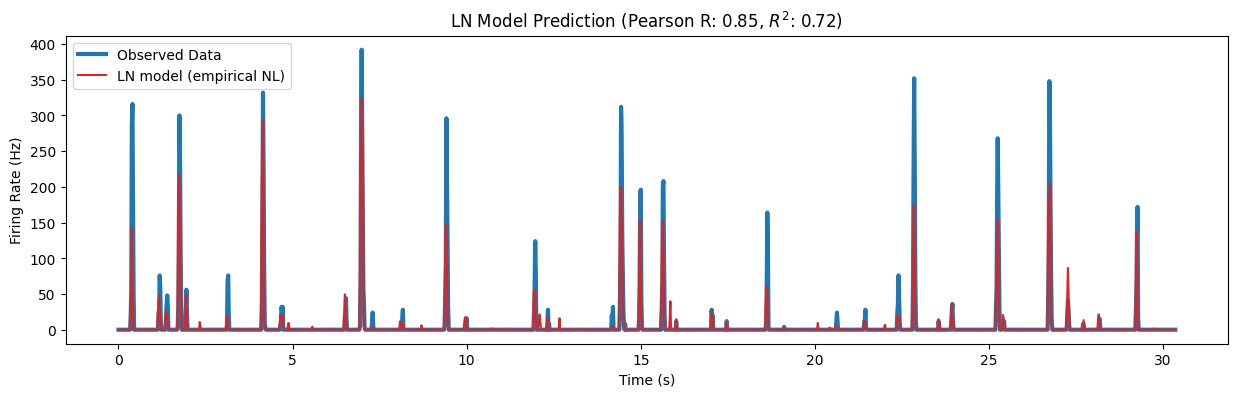

Pearson R: 0.85
R^2: 0.72


In [489]:
def predict_FR(test_stim, test_psth, sta, num_past_pulses, optimal_parameters, 
               frame_rate=60, nonlinearity_type="exponential", empirical_nl=None):

    # Convolve the test stimulus with the STA
    test_convolved = convolve_stimulus_with_sta(test_stim, sta, plotFlag=False)[0]
    
    if nonlinearity_type == "sigmoid":
        def sigmoid(x, L, k, x0):
            return L / (1 + np.exp(-k * (x - x0)))
        y_predicted = sigmoid(test_convolved, *optimal_parameters)
        
    elif nonlinearity_type == "exponential":
        def exponential(x, a, b, c,d):
            return a * np.exp(b * x + c)+d
        y_predicted = exponential(test_convolved, *optimal_parameters)
        
    elif nonlinearity_type == "empirical":
        if empirical_nl is None:
            raise ValueError("For 'empirical' nonlinearity, `empirical_nl` must be provided.")
        # Digitize test_convolved to align with empirical NL
        bins = np.linspace(test_convolved.min(), test_convolved.max(), len(empirical_nl))
        digitized_indices = np.digitize(test_convolved, bins) - 1
        y_predicted = empirical_nl[digitized_indices]
    elif nonlinearity_type == "softplus":
        def softplus(x, a, b, c,d):
            return a * np.log(1 + np.exp(b * x + c)) +d
        y_predicted = softplus(test_convolved, *optimal_parameters)
    else:
        raise ValueError("Invalid nonlinearity type. Choose 'sigmoid', 'exponential', or 'empirical'.")
    
    # Convert to firing rate (Hz)
    bin_duration = 1 / frame_rate  # Duration of each bin in seconds
    y_predicted = y_predicted / bin_duration  # Convert to Hz

    time_axis = np.arange(len(test_psth[num_past_pulses:])) * bin_duration  # in seconds

    observed = test_psth[num_past_pulses:]  # Observed firing rate
    pearson_r, _ = pearsonr(observed, y_predicted)
    r_squared = r2_score(observed, y_predicted)


    fig, ax = plt.subplots(figsize=(15, 4))
    ax.plot(time_axis, observed, lw=3, c="tab:blue", label="Observed Data")
    ax.plot(time_axis, y_predicted, lw=1.5, c="tab:red", label=f"LN model ({nonlinearity_type} NL)")
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Firing Rate (Hz)")
    ax.set_title(f"LN Model Prediction (Pearson R: {pearson_r:.2f}, $R^2$: {r_squared:.2f})")
    plt.legend()
    # plt.ylim(-10, 25)
    plt.show()


    print(f"Pearson R: {pearson_r:.2f}")
    print(f"R^2: {r_squared:.2f}")

    return time_axis, y_predicted

time_axis, y_predicted = predict_FR(test_stim, test_psth, sta, num_past_pulses, optimal_parameters_exp, 
               frame_rate=60, nonlinearity_type="empirical", empirical_nl=eNL)